Trying to reproduce https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a
no wait, this one works much better:
https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

In [73]:
#!pip install --user git+https://github.com/markusloecher/shap
#!pip install StringIO

In [10]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt

#from StringIO import StringIO

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree.export import export_graphviz
from sklearn.feature_selection import mutual_info_classif
from sklearn import tree

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.tree.export module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df = pd.read_csv('./titanicnoMissingAge.csv') # Load the data
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",2,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",2,35.0,0,0,373450,8.0500,NaN,S
5,7,0,1,"McCarthy, Mr. Timothy J",2,54.0,0,0,17463,51.8625,E46,S
6,8,0,3,"Palsson, Master. Gosta Leonard",2,2.0,3,1,349909,21.0750,NaN,S
7,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,27.0,0,2,347742,11.1333,NaN,S
8,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,14.0,1,0,237736,30.0708,NaN,C
9,11,1,3,"Sandstrom, Miss. Marguerite Rut",1,4.0,1,1,PP 9549,16.7000,G6,S


In [56]:

Y = df['Survived']
X =  df[['Age', 'Pclass','Sex', 'PassengerId']]
clf = DecisionTreeClassifier(max_leaf_nodes=6, random_state=0)
clf.fit(X, Y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=6,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [57]:
importances = clf.tree_.compute_feature_importances(normalize=False)
print("feat importance = " + str(importances))


feat importance = [0.01511054 0.05559453 0.14005346 0.00687031]


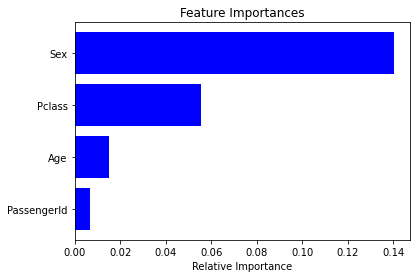

In [45]:
#out = StringIO()
#out = export_graphviz(clf, out_file='test/tree.dot')
features = X.columns
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [58]:
def get_node_depth(estimator):
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right
    feature = estimator.tree_.feature
    threshold = estimator.tree_.threshold
    
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True
            
    return node_depth

get_node_depth(clf)

array([0, 1, 1, 2, 2, 2, 2, 3, 3, 4, 4], dtype=int64)

[Text(148.8, 195.696, 'X[2] <= 1.5\ngini = 0.482\nsamples = 714\nvalue = [424, 290]'),
 Text(74.4, 152.208, 'X[1] <= 2.5\ngini = 0.37\nsamples = 261\nvalue = [64, 197]'),
 Text(37.2, 108.72, 'gini = 0.107\nsamples = 159\nvalue = [9, 150]'),
 Text(111.60000000000001, 108.72, 'gini = 0.497\nsamples = 102\nvalue = [55, 47]'),
 Text(223.20000000000002, 152.208, 'X[0] <= 6.5\ngini = 0.326\nsamples = 453\nvalue = [360, 93]'),
 Text(186.0, 108.72, 'gini = 0.444\nsamples = 24\nvalue = [8, 16]'),
 Text(260.40000000000003, 108.72, 'X[1] <= 1.5\ngini = 0.295\nsamples = 429\nvalue = [352, 77]'),
 Text(223.20000000000002, 65.232, 'X[3] <= 548.5\ngini = 0.473\nsamples = 99\nvalue = [61, 38]'),
 Text(186.0, 21.744, 'gini = 0.379\nsamples = 59\nvalue = [44, 15]'),
 Text(260.40000000000003, 21.744, 'gini = 0.489\nsamples = 40\nvalue = [17, 23]'),
 Text(297.6, 65.232, 'gini = 0.208\nsamples = 330\nvalue = [291, 39]')]

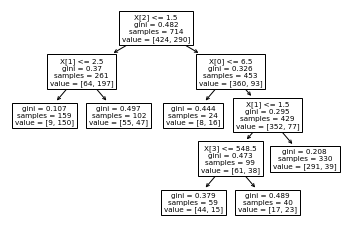

In [67]:
tree.plot_tree(clf )

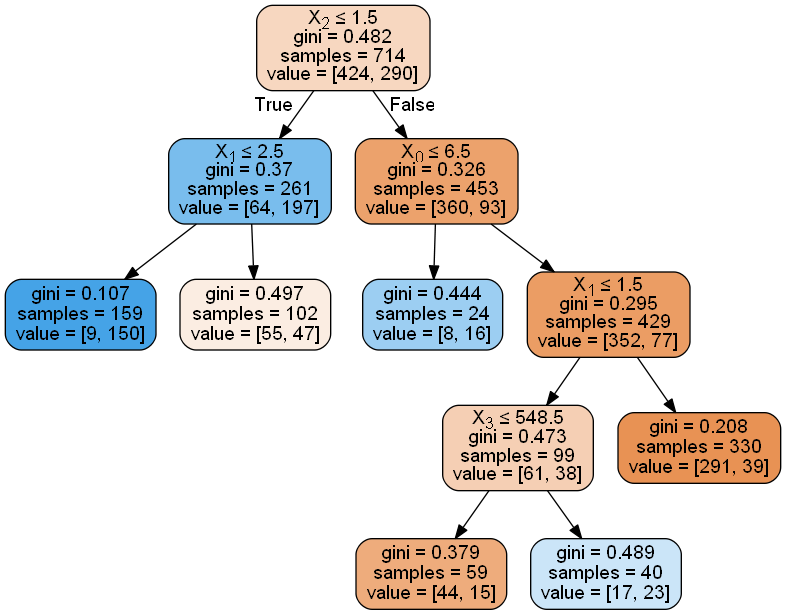

In [46]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())


### Pruning the tree

In [61]:
from sklearn.tree._tree import TREE_LEAF

def prune_by_node_sample_size(inner_tree, index, threshold=2):
    p_index=index
    leftChild=inner_tree.children_left[p_index]
    rightChild=inner_tree.children_right[p_index]
    nodes2remove
    if clf.tree_.n_node_samples[leftChild] < threshold:
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
    if clf.tree_.n_node_samples[rightChild] < threshold:
        inner_tree.children_right[index] = TREE_LEAF
        
    # recursive: if there are shildren, visit them as well
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_by_node_sample_size(inner_tree, inner_tree.children_left[index], threshold)
    if inner_tree.children_right[index] != TREE_LEAF:
        prune_by_node_sample_size(inner_tree, inner_tree.children_right[index], threshold)
         


In [72]:
import copy
#copy.copy(x)
clf_pruned = copy.deepcopy(clf)
clf_pruned.tree_.nodes2remove = False
print(clf_pruned.tree_.children_left, clf_pruned.tree_.children_right)

AttributeError: 'sklearn.tree._tree.Tree' object has no attribute 'nodes2remove'

In [71]:
print(sum(clf_pruned.tree_.children_left < 0))
# start pruning from the root
prune_by_node_sample_size(clf_pruned.tree_, 0, 150)
#sum(clf_pruned.tree_.children_left < 0)
print(clf_pruned.tree_.children_left, clf_pruned.tree_.children_right)
get_node_depth(clf_pruned)

6
[ 1  3 -1 -1 -1 -1 -1  9 -1 -1 -1] [ 2 -1  6 -1 -1 -1  8 10 -1 -1 -1]


array([0, 1, 1, 2, 0, 0, 2, 0, 3, 0, 2], dtype=int64)

[Text(148.8, 195.696, 'X[2] <= 1.5\ngini = 0.482\nsamples = 714\nvalue = [424, 290]'),
 Text(74.4, 152.208, 'X[1] <= 2.5\ngini = 0.37\nsamples = 261\nvalue = [64, 197]'),
 Text(37.2, 108.72, 'gini = 0.107\nsamples = 159\nvalue = [9, 150]'),
 Text(111.60000000000001, 108.72, 'gini = 0.497\nsamples = 102\nvalue = [55, 47]'),
 Text(223.20000000000002, 152.208, 'X[0] <= 6.5\ngini = 0.326\nsamples = 453\nvalue = [360, 93]'),
 Text(186.0, 108.72, 'gini = 0.444\nsamples = 24\nvalue = [8, 16]'),
 Text(260.40000000000003, 108.72, 'X[1] <= 1.5\ngini = 0.295\nsamples = 429\nvalue = [352, 77]'),
 Text(223.20000000000002, 65.232, 'X[3] <= 548.5\ngini = 0.473\nsamples = 99\nvalue = [61, 38]'),
 Text(186.0, 21.744, 'gini = 0.379\nsamples = 59\nvalue = [44, 15]'),
 Text(260.40000000000003, 21.744, 'gini = 0.489\nsamples = 40\nvalue = [17, 23]'),
 Text(297.6, 65.232, 'gini = 0.208\nsamples = 330\nvalue = [291, 39]')]

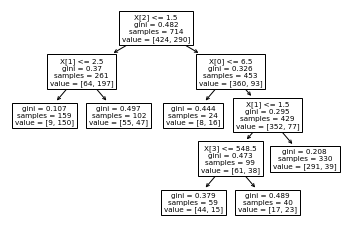

In [68]:
#clf.tree_.n_node_samples
#p_index=0
#leftChild=clf.tree_.children_left[p_index]
#rightChild=clf.tree_.children_right[p_index]
#print(clf.tree_.n_node_samples[p_index], clf.tree_.n_node_samples[leftChild], clf.tree_.n_node_samples[rightChild])

tree.plot_tree(clf_pruned)

In [64]:
dot_data = StringIO()
export_graphviz(clf_pruned, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())

ValueError: Invalid node_id -1

In [41]:
importances = clf.tree_.compute_feature_importances(normalize=False)
print("feat importance = " + str(importances))

feat importance = [0.         0.01505444 0.14005346 0.00687031]


In [42]:
get_node_depth(clf)

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [48]:
clf.tree_.n_node_samples

array([714, 261, 453, 159, 102,  24, 429,  99, 330,  59,  40], dtype=int64)